<a href="https://colab.research.google.com/github/Aryayayayaa/Brain-MRI-Image_Classification/blob/main/BrainMRIImgClassifn_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Name    - NeuroScan AI: Precision Brain Tumor Insight**



# **Problem Statement:**

This project aims to develop a deep learning-based solution for classifying brain MRI images into multiple categories according to tumor type. It involves building a custom CNN model from scratch and enhancing performance through transfer learning using pretrained models. The project also includes deploying a user-friendly Streamlit web application to enable real-time tumor type predictions from uploaded MRI images.

# **Project Summary -**

This project, **"NeuroScan AI: Precision Brain Tumor Insight"**, delivers an end-to-end deep learning solution for the automated classification of brain MRI images. The primary objective is to accurately identify four distinct categories: **Glioma Tumor, Meningioma Tumor, No Tumor, and Pituitary Tumor**, thereby providing a valuable AI-assisted tool for medical image analysis.

The development process followed a robust machine learning workflow:

1. **Data Acquisition & Preprocessing:** The project began with loading and preparing a comprehensive dataset of brain MRI scans. This involved rigorous data preprocessing, including pixel normalization and strategic data augmentation (rotation, flipping, zooming, translation) to artificially expand the training data and enhance model generalization, crucial for medical imaging tasks.

2. **Model Development:** Two distinct deep learning approaches were explored:

  * A Custom Convolutional Neural Network (CNN) was designed from scratch, incorporating advanced layers like Batch Normalization and Dropout to build a robust and efficient classifier.

  * Transfer Learning models (e.g., MobileNetV2) were utilized, leveraging pre-trained weights from large-scale image datasets. This involved replacing the top classification layers with custom dense layers tailored for tumor categories, with an option for fine-tuning the base model.

3. **Model Training & Optimization:** Both the custom CNN and transfer learning models were trained using TensorFlow and Keras. The training process was optimized with callbacks such as EarlyStopping to prevent overfitting and ModelCheckpoint to automatically save the best-performing model based on validation loss, ensuring efficient resource utilization and optimal model convergence.

4. **Comprehensive Model Evaluation & Comparison:** Models were rigorously evaluated using a suite of metrics including accuracy, precision, recall, F1-score, and confusion matrices. A programmatic comparison identified the most accurate and reliable model for deployment, with the Custom CNN demonstrating superior and balanced performance across all classes in this iteration.


5. **Interactive Web Application Deployment:** The culmination of the project is an intuitive and interactive web application built with Streamlit. Users can easily upload MRI images, receive instant predictions of tumor types, view model confidence scores, and critically, understand the model's uncertainty. The application features a custom, professional background to enhance the user experience, along with clear disclaimers emphasizing its role as an AI-assisted tool, not a diagnostic substitute.

This project showcases a comprehensive understanding of deep learning principles, practical model development, robust evaluation methodologies, and responsible deployment strategies, all tailored for a high-impact application in medical imaging.

# **GitHub Link:**



https://github.com/Aryayayayaa/Labmentix/blob/9b76d5037db6f0a91d21c8145adb18876e1ff46a/BrainMRIImgClassifn_Code.ipynb

# **Code:**

In [ ]:
# @title Importing Libraries

import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers, models, Model
from tensorflow.keras.applications import (ResNet50, MobileNetV2, InceptionV3, EfficientNetB0)
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image                                # For image loading and preprocessing
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os
from google.colab import drive
from collections import Counter
from PIL import Image                                                           # Required for checking original image resolutions

In [ ]:
# @title Google Drive Steps

drive.mount('/content/drive')

BASE_DATA_DIR = '/content/drive/My Drive/Brain Tumor MRI Img Classification/Tumour Dataset/Tumour'

TRAIN_DIR = os.path.join(BASE_DATA_DIR, 'train')
VALID_DIR = os.path.join(BASE_DATA_DIR, 'valid')
TEST_DIR = os.path.join(BASE_DATA_DIR, 'test')

# Define target image size and batch size for model input
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# Define the classes based on your folder names
CLASSES = ['glioma', 'meningioma', 'no_tumor', 'pituitary']
NUM_CLASSES = len(CLASSES)

print(TRAIN_DIR)
print(VALID_DIR)
print(TEST_DIR)

#print(f"Dataset root directory: {BASE_DATA_DIR}")
#print(f"Image dimensions for processing: {IMG_HEIGHT}x{IMG_WIDTH}")
#print(f"Batch size: {BATCH_SIZE}")
#print(f"Tumor classes: {CLASSES}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Brain Tumor MRI Img Classification/Tumour Dataset/Tumour/train
/content/drive/My Drive/Brain Tumor MRI Img Classification/Tumour Dataset/Tumour/valid
/content/drive/My Drive/Brain Tumor MRI Img Classification/Tumour Dataset/Tumour/test


In [ ]:
# @title Load Datasets
# Images will be resized upon loading, but pixel values will remain in their original range (0-255).

# Load the training dataset - shuffle for effective training, as data order matters for SGD-based optimizers.
print("Loading Training Dataset...")
train_ds = image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',           # Labels are inferred from subdirectory names
    label_mode='categorical',    # For one-hot encoded labels
    image_size=(IMG_HEIGHT, IMG_WIDTH), # Images are resized during loading
    batch_size=BATCH_SIZE,
    shuffle=True                 # Shuffle the training data
)

# Load the validation dataset - do not shuffle validation data as order does not impact evaluation, and it allows for consistent monitoring.
print("\nLoading Validation Dataset...")
valid_ds = image_dataset_from_directory(
    VALID_DIR,
    labels='inferred',
    label_mode='categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Load the test dataset - do not shuffle test data for consistent and reproducible evaluation.
print("\nLoading Test Dataset...")
test_ds = image_dataset_from_directory(
    TEST_DIR,
    labels='inferred',
    label_mode='categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=False
)

print("\nAll datasets loaded (train, validation, test).")
print(f"Inferred Class Names: {train_ds.class_names}")


Loading Training Dataset...
Found 1695 files belonging to 4 classes.

Loading Validation Dataset...
Found 502 files belonging to 4 classes.

Loading Test Dataset...
Found 246 files belonging to 4 classes.

All datasets loaded (train, validation, test).
Inferred Class Names: ['glioma', 'meningioma', 'no_tumor', 'pituitary']



--- Starting Dataset Analysis (with crash prevention) ---

1. Checking for Class Imbalance:

--- Training Dataset Class Distribution ---
  Processing dataset (batches of None images)...
  Total samples found: 1695
  Class distribution:
    - pituitary: 438 samples (25.84%)
    - glioma: 564 samples (33.27%)
    - meningioma: 358 samples (21.12%)
    - no_tumor: 335 samples (19.76%)

--- Validation Dataset Class Distribution ---
  Processing dataset (batches of None images)...
  Total samples found: 502
  Class distribution:
    - glioma: 161 samples (32.07%)
    - meningioma: 124 samples (24.70%)
    - no_tumor: 99 samples (19.72%)
    - pituitary: 118 samples (23.51%)

--- Test Dataset Class Distribution ---
  Processing dataset (batches of None images)...
  Total samples found: 246
  Class distribution:
    - glioma: 80 samples (32.52%)
    - meningioma: 63 samples (25.61%)
    - no_tumor: 49 samples (19.92%)
    - pituitary: 54 samples (21.95%)

2. Checking Original Image Resolutio

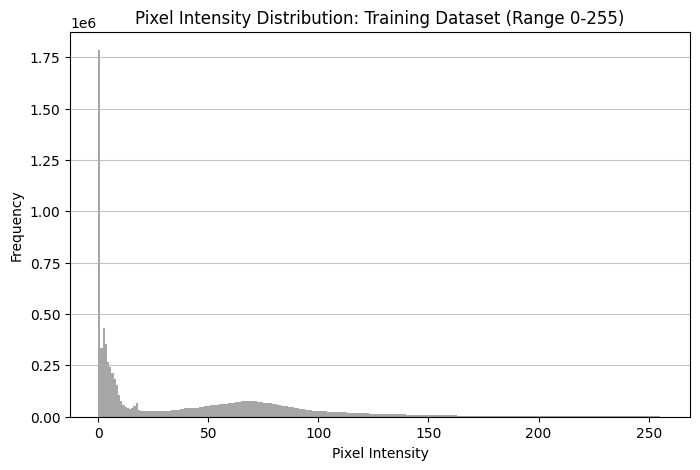

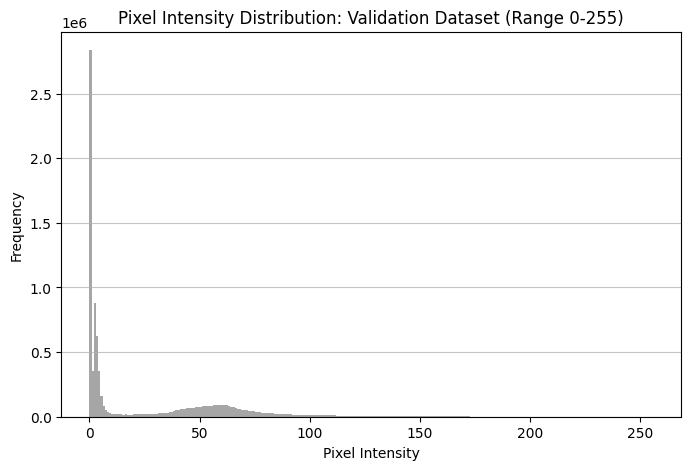

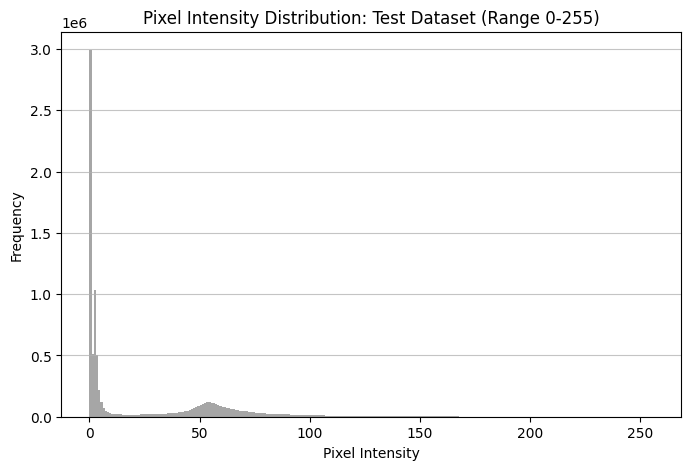


4. Visualizing Sample Images Per Class:
  (Displaying a few samples for each tumor type/class from the training dataset)


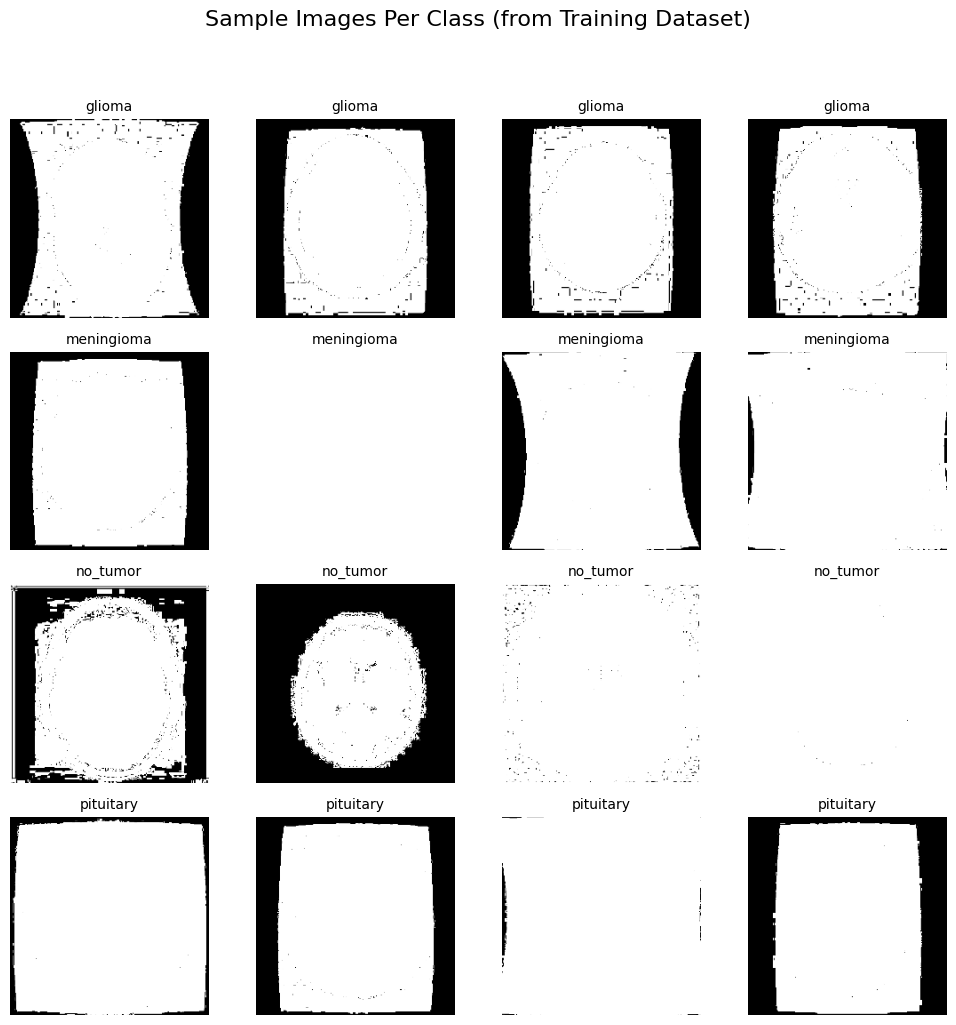


Dataset analysis complete. Review the outputs above for insights into your data.


In [ ]:
# @title Dataset Analysis Section

import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import Counter
from PIL import Image # Required for checking original image resolutions

CLASS_NAMES = train_ds.class_names if hasattr(train_ds, 'class_names') else CLASSES

print("\n--- Starting Dataset Analysis (with crash prevention) ---")

# --- 1. Check for Class Imbalance (No changes needed here) ---
print("\n1. Checking for Class Imbalance:")

def get_class_counts(dataset, class_names):
    class_counts = Counter()
    total_samples = 0
    print(f"  Processing dataset (batches of {dataset.element_spec[0].shape[0] if dataset.element_spec else 'None'} images)...")
    for images, labels in dataset:
        class_indices = tf.argmax(labels, axis=1).numpy()
        class_counts.update(class_indices)
        total_samples += len(images)
    print(f"  Total samples found: {total_samples}")
    named_counts = {class_names[idx]: count for idx, count in class_counts.items()}
    print("  Class distribution:")
    for name, count in named_counts.items():
        percentage = (count / total_samples) * 100 if total_samples > 0 else 0
        print(f"    - {name}: {count} samples ({percentage:.2f}%)")
    return named_counts, total_samples

print("\n--- Training Dataset Class Distribution ---")
train_class_counts, _ = get_class_counts(train_ds, CLASS_NAMES)

print("\n--- Validation Dataset Class Distribution ---")
valid_class_counts, _ = get_class_counts(valid_ds, CLASS_NAMES)

print("\n--- Test Dataset Class Distribution ---")
test_class_counts, _ = get_class_counts(test_ds, CLASS_NAMES)

# --- 2. Check for Original Image Resolution Consistency (No changes needed here) ---
print("\n2. Checking Original Image Resolution Consistency (from disk):")

def check_original_resolutions(data_dir):
    resolutions = Counter()
    image_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')
    if not os.path.exists(data_dir):
        print(f"  Warning: Directory not found for original resolution check: {data_dir}")
        return None
    print(f"  Scanning original images in: {data_dir}...")
    for root, _, files in os.walk(data_dir):
        for file in files:
            if file.lower().endswith(image_extensions):
                file_path = os.path.join(root, file)
                try:
                    with Image.open(file_path) as img:
                        resolutions[(img.width, img.height)] += 1
                except Exception as e:
                    print(f"  Could not read image {file_path}: {e}")
    print("\n  Original Image Resolutions Found:")
    if not resolutions:
        print("  No image files found in the specified directory or its subfolders.")
        return None
    for res, count in resolutions.most_common():
        print(f"    - {res[0]}x{res[1]}: {count} images")
    if len(resolutions) > 1:
        print("\n  **Note: Multiple original resolutions found. They are resized to 224x224 during dataset loading.**")
    else:
        print("\n  All original images found have a consistent resolution.")
    return resolutions

print("\n--- Original Resolutions in Training Data Folder ---")
train_original_res = check_original_resolutions(TRAIN_DIR)

print("\n--- Original Resolutions in Validation Data Folder ---")
valid_original_res = check_original_resolutions(VALID_DIR)

print("\n--- Original Resolutions in Test Data Folder ---")
test_original_res = check_original_resolutions(TEST_DIR)


# --- 3. Explore Image Distributions Visually (Pixel Intensity Histograms) ---
print("\n3. Exploring Image Distributions Visually (Pixel Intensity Histograms):")
print("  (Showing distributions for currently loaded datasets; pixel values are 0-255)")

def plot_pixel_intensity_histogram(dataset, title, num_batches_to_sample=2):
    all_pixels = []
    print(f"  Collecting pixel data from {num_batches_to_sample} batches of {title}...")

    for images, _ in dataset.take(num_batches_to_sample):
        pixels = images.numpy().flatten()
        all_pixels.extend(pixels)

    if not all_pixels:
        print(f"  No pixel data collected from {title}. Ensure dataset is not empty or sampled batches are too few.")
        return

    plt.figure(figsize=(8, 5))
    plt.hist(all_pixels, bins=256, range=[0, 256], color='gray', alpha=0.7)
    plt.title(f'Pixel Intensity Distribution: {title} (Range 0-255)')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

plot_pixel_intensity_histogram(train_ds, "Training Dataset", num_batches_to_sample=2)
plot_pixel_intensity_histogram(valid_ds, "Validation Dataset", num_batches_to_sample=2)
plot_pixel_intensity_histogram(test_ds, "Test Dataset", num_batches_to_sample=2)


# --- 4. Visualize Sample Images Per Class (NEW SECTION) ---
print("\n4. Visualizing Sample Images Per Class:")
print("  (Displaying a few samples for each tumor type/class from the training dataset)")

def visualize_samples_per_class(dataset, class_names, num_samples_per_class=3):
    """
    Displays a grid of sample images for each class from a TensorFlow dataset.
    """
    class_images = {name: [] for name in class_names}

    # Collect a few samples for each class
    # Iterate through the dataset until we have enough samples for each class
    print(f"  Collecting {num_samples_per_class} samples for each class...")
    for images, labels in dataset.unbatch(): # Unbatch to process individual images
        class_idx = tf.argmax(labels).numpy()
        class_name = class_names[class_idx]

        if len(class_images[class_name]) < num_samples_per_class:
            class_images[class_name].append(images.numpy())

        # Check if we have enough samples for all classes
        if all(len(v) == num_samples_per_class for v in class_images.values()):
            break # Stop iterating if all classes are filled

    # Plot the collected samples
    num_classes = len(class_names)
    fig, axes = plt.subplots(num_classes, num_samples_per_class, figsize=(num_samples_per_class * 2.5, num_classes * 2.5))

    if num_classes == 1: # Handle case with only one class to avoid indexing errors
        axes = np.expand_dims(axes, axis=0)
    if num_samples_per_class == 1: # Handle case with only one sample per class
        axes = np.expand_dims(axes, axis=1)

    for i, class_name in enumerate(class_names):
        for j in range(num_samples_per_class):
            ax = axes[i, j]
            if j < len(class_images[class_name]):
                img_data = class_images[class_name][j]
                # Ensure image is 2D for grayscale display if it's (H, W, 1)
                if img_data.shape[-1] == 1:
                    img_data = img_data.squeeze() # Remove the last dimension
                ax.imshow(img_data, cmap='gray') # Use cmap='gray' for MRI images
                ax.set_title(f"{class_name}", fontsize=10)
                ax.axis("off")
            else:
                ax.axis("off") # Hide empty subplots if not enough samples

    plt.suptitle("Sample Images Per Class (from Training Dataset)", fontsize=16, y=1.02)
    plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust layout to prevent title overlap
    plt.show()

# Call the new visualization function for the training dataset
visualize_samples_per_class(train_ds, CLASS_NAMES, num_samples_per_class=4) # Display 4 samples per class


print("\nDataset analysis complete. Review the outputs above for insights into your data.")

In [ ]:
# @title Data Preprocessing: Only Normalization required

# Normalize pixel values to a 0-1 range

# Define the normalization layer: it scales pixel values from [0, 255] to [0, 1] by dividing each pixel value by 255.
normalization_layer = layers.Rescaling(1./255)

print("\nApplying normalization to datasets (rescaling pixel values to 0-1)...")

# Apply the normalization layer to each dataset using the map method - applies a transformation to each element (image, label pair) of the dataset.
train_ds_normalized = train_ds.map(lambda x, y: (normalization_layer(x), y))
valid_ds_normalized = valid_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds_normalized = test_ds.map(lambda x, y: (normalization_layer(x), y))

print("Datasets normalized.")
print("The images in your datasets (train_ds_normalized, valid_ds_normalized, test_ds_normalized)")
print(f"are now {IMG_HEIGHT}x{IMG_WIDTH} pixels with values between 0 and 1.")

# Verify the normalization and size - take one batch from the normalized training dataset to check its properties
for images, labels in train_ds_normalized.take(1):
    print(f"\nExample batch shape (images from normalized train_ds): {images.shape}")
    print(f"Example image data type (after normalization): {images.dtype}") # Should be tf.float32
    print(f"Min pixel value in a sample image: {tf.reduce_min(images[0]).numpy()}")
    print(f"Max pixel value in a sample image: {tf.reduce_max(images[0]).numpy()}")
    break # Only take one batch for verification



Applying normalization to datasets (rescaling pixel values to 0-1)...
Datasets normalized.
The images in your datasets (train_ds_normalized, valid_ds_normalized, test_ds_normalized)
are now 224x224 pixels with values between 0 and 1.

Example batch shape (images from normalized train_ds): (32, 224, 224, 3)
Example image data type (after normalization): <dtype: 'float32'>
Min pixel value in a sample image: 0.0
Max pixel value in a sample image: 0.9240100383758545



Data Augmentation Setup
Data augmentation layers defined.

Visualizing Augmented Images
This shows the effect of the defined augmentation layers.


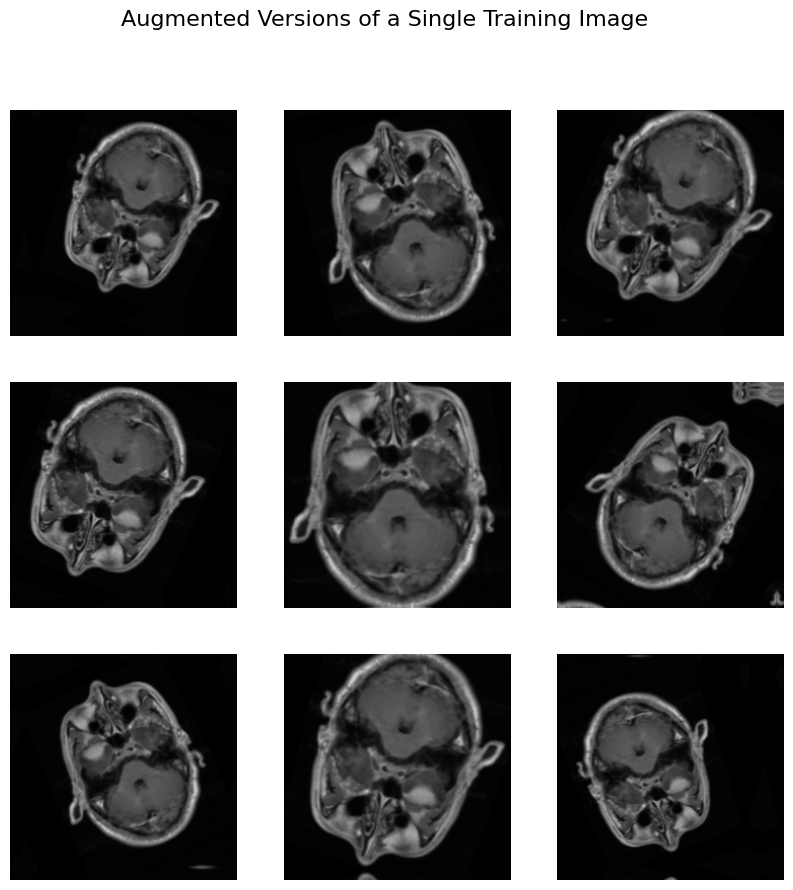


Data augmentation setup complete.


In [ ]:
# @title Data Augmentation

print("\nData Augmentation Setup")

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.1),                                                 # Rotate by max 10% * 2pi radians
    layers.RandomZoom(0.2),                                                     # Randomly zoom into or out of the image by up to 20%.
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),              # Randomly shift the image horizontally or vertically by up to 10% of the image height/width.

    # Optional: Randomly adjust brightness by up to 20%. Use with caution for medical images.
    # layers.RandomBrightness(factor=0.2),

    # Optional: Randomly adjust contrast. Use with caution for medical images.
    # layers.RandomContrast(factor=0.2),

], name="data_augmentation_layers")

print("Data augmentation layers defined.")


# This part helps you see what the augmentation does to your images.
print("\nVisualizing Augmented Images")
print("This shows the effect of the defined augmentation layers.")

# Take one batch from the normalized training dataset
# .take(1) gets the first batch, .as_numpy_iterator() converts to numpy arrays for visualization
for images, labels in train_ds_normalized.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0] # Take the first image from the batch to augment

    for i in range(9): # Show 9 augmented versions of this single image
        ax = plt.subplot(3, 3, i + 1)

        # Apply augmentation to the single image (tf.expand_dims adds a batch dimension as augmentation layers expect batched input)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))

        # Display the image (remove batch dimension with [0])
        plt.imshow(augmented_image[0].numpy(), cmap='gray') # Use cmap='gray' for MRI images
        plt.axis("off")

    plt.suptitle("Augmented Versions of a Single Training Image", fontsize=16)
    plt.show()

    break # Only process and visualize one batch

print("\nData augmentation setup complete.")

In [ ]:
# @title Custom CNN Model

print("\n--- Building Custom CNN Model ---")

def build_custom_cnn(input_shape, num_classes):
    model = models.Sequential([

        layers.InputLayer(input_shape=input_shape),

        # Convolutional Block 1
        # Conv2D: 32 filters, 3x3 kernel. 'padding="same"' ensures output size matches input for first layers.
        # use_bias=False: Often used with BatchNormalization as BN layers have their own learnable bias.
        layers.Conv2D(32, (3, 3), padding='same', use_bias=False),              # performs a convolution operation on the input image
        layers.BatchNormalization(),                                            # Normalizes activations
        layers.Activation('relu'),                                              # Non-linear activation
        layers.MaxPooling2D((2, 2)),                                            # Downsamples by 2x2

        # Convolutional Block 2
        layers.Conv2D(64, (3, 3), padding='same', use_bias=False),              # Increase filters to learn more complex features
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),

        # Convolutional Block 3
        layers.Conv2D(128, (3, 3), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),

        # Convolutional Block 4 (Optional, for deeper feature extraction)
        layers.Conv2D(256, (3, 3), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),

        # Flatten Layer: Converts the 3D output (height, width, filters) of Conv2D layers into a 1D vector for input into the fully connected (Dense) layers.
        layers.Flatten(),

        # Dense Layer 1 (Hidden Layer)
        layers.Dense(512, use_bias=False),                                      # 512 neurons
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.5), # Dropout: randomly sets 50% of input units to 0 at each update during training: prevents overfitting

        # Dense Layer 2 (Hidden Layer)
        layers.Dense(256, use_bias=False),                                      # 256 neurons
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.3),                                                    # Slightly lower dropout rate

        # Output Layer: no. of units must be equal to the number of classes.
        # 'softmax' activation outputs a probability distribution over the classes.
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Define the input shape for the model: assuming IMG_HEIGHT, IMG_WIDTH are 224, and images are loaded as 3 channels (default)
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

# Build an instance of the custom CNN model
custom_cnn_model = build_custom_cnn(input_shape, NUM_CLASSES)

print("\nCustom CNN Model Summary:")
custom_cnn_model.summary()

print("\n--- Model Building Complete ---")
print("Your custom CNN model has been designed with:")
print("- Multiple Convolutional and MaxPooling layers for hierarchical feature extraction.")
print("- Batch Normalization layers to stabilize and accelerate training.")
print("- Dropout layers strategically placed in dense layers to combat overfitting.")
print("- A final softmax activation layer for multi-class probability output.")


--- Building Custom CNN Model ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Custom CNN Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       294,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    25,690,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,072 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 26,215,140 (100.00 MB)

 Trainable params: 26,212,644 (99.99 MB)

 Non-trainable params: 2,496 (9.75 KB)


--- Model Building Complete ---
Your custom CNN model has been designed with:
- Multiple Convolutional and MaxPooling layers for hierarchical feature extraction.
- Batch Normalization layers to stabilize and accelerate training.
- Dropout layers strategically placed in dense layers to combat overfitting.
- A final softmax activation layer for multi-class probability output.


In [ ]:
# @title Transfer Learning

print("Setting up Transfer Learning Model Building")

# Define common input shape for pre-trained models
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)                                        # Assumes 3 channels, as loaded by default

def create_transfer_learning_model(base_model_name, input_shape, num_classes, fine_tune_at=0):
    """
    Args:
        base_model_name (str): Name of the pre-trained model ('MobileNetV2', 'ResNet50', etc.)
        input_shape (tuple): Expected input image shape (height, width, channels).
        num_classes (int): Number of output classes for your specific task.
        fine_tune_at (int): Number of top layers to unfreeze for fine-tuning.
                            0 means the base model remains completely frozen.
                            A positive integer means that many layers from the end of the base model are unfrozen.
    Returns:
        tf.keras.Model: The compiled transfer learning model.
        base_model: The unfrozen base model (for more fine-tuning control if needed).
    """

    # Load the Pre-trained Base Model

    # include_top=False: removes the original ImageNet classification head.
    # weights='imagenet': initializes the model with weights pre-trained on ImageNet.

    print(f"\nLoading {base_model_name} base model with ImageNet weights...")

    if base_model_name == 'MobileNetV2':
        base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
        preprocess_input_fn = tf.keras.applications.mobilenet_v2.preprocess_input

    elif base_model_name == 'ResNet50':
        base_model = ResNet50(input_shape=input_shape, include_top=False, weights='imagenet')
        preprocess_input_fn = tf.keras.applications.resnet50.preprocess_input

    elif base_model_name == 'InceptionV3': # InceptionV3 typically prefers 299x299 input, ensure your IMG_HEIGHT/WIDTH are set accordingly

        if input_shape != (299, 299, 3):
             print(f"Warning: InceptionV3 usually prefers 299x299 input. Current input_shape is {input_shape}")

        base_model = InceptionV3(input_shape=input_shape, include_top=False, weights='imagenet')
        preprocess_input_fn = tf.keras.applications.inception_v3.preprocess_input

    elif base_model_name == 'EfficientNetB0':
        base_model = EfficientNetB0(input_shape=input_shape, include_top=False, weights='imagenet')
        preprocess_input_fn = tf.keras.applications.efficientnet.preprocess_input

    else:
        raise ValueError(f"Unknown base model: {base_model_name}")

    # Set the base model to be non-trainable initially (Feature Extraction Phase)
    # freezes its weights: they won't be updated during the first training phase.
    base_model.trainable = False
    print(f"{base_model_name} base model layers set to non-trainable (frozen).")




    # Build the New Classification Head

    # Use the Functional API for clearer definition of layers
    inputs = tf.keras.Input(shape=input_shape)

    # Pixel normalization (0-1 range) - if not already mapped to your dataset
    x = layers.Rescaling(1./255)(inputs)

    # Preprocessing specific to the chosen pre-trained model (e.g., scaling to -1 to 1)
    x = preprocess_input_fn(x)

    # Pass through the frozen base model
    x = base_model(x, training=False) # Important: training=False when base_model.trainable=False

    # Add new layers for your specific classification task
    x = layers.GlobalAveragePooling2D()(x) # Reduces spatial dimensions to a single vector

    # Add a BatchNormalization layer after pooling for stability
    x = layers.BatchNormalization()(x) # Added this layer

    x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x) # Increased units, added L2 regularization
    x = layers.Dropout(0.5)(x) # Increased dropout rate

    x = layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x) # A dense layer with ReLU activation
    x = layers.Dropout(0.4)(x) # Dropout for regularization

    outputs = layers.Dense(num_classes, activation='softmax')(x) # Final classification layer


    # Create the full model
    model = Model(inputs, outputs)

    # Compile the model
    # For initial training (with frozen base), a higher learning rate is often fine.
    # When fine-tuning, a much smaller learning rate is crucial.
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    print(f"\nModel with {base_model_name} base and new head created and compiled.")
    print("Model Summary (initial frozen base):")
    model.summary()

    # Handle optional fine-tuning setup for later

    if fine_tune_at > 0:
        print(f"\nPreparing for fine-tuning: Unfreezing top {fine_tune_at} layers of {base_model_name} base model...")
        base_model.trainable = True

        # Freeze all layers before the `fine_tune_at` layer
        for layer in base_model.layers[:-fine_tune_at]:
            layer.trainable = False

        print("Model Summary (after unfreezing for fine-tuning):")
        # Recompile the model with a much lower learning rate for fine-tuning
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-6), # Very low learning rate!
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        model.summary()
        print(f"**IMPORTANT:** After unfreezing layers, you must recompile the model with a very low learning rate.")

    return model, base_model


# Example with MobileNetV2: initially, we keep the base model frozen (fine_tune_at=0).
print("\n--- Example: Building a MobileNetV2-based Model (Feature Extraction Phase) ---")
transfer_model_mbv2, _ = create_transfer_learning_model(
    'MobileNetV2',
    input_shape=INPUT_SHAPE,
    num_classes=NUM_CLASSES,
    fine_tune_at=0                                                              # Keep base model frozen for initial training
)

# You can now use transfer_model_mbv2 to train your model:
history = transfer_model_mbv2.fit(train_ds_normalized, validation_data=valid_ds_normalized, epochs=10)


'''
print("\n--- Example: Preparing MobileNetV2 Model for Fine-Tuning ---")

# We'll create a new model instance here just for demonstration of unfreezing.
transfer_model_mbv2_finetune, base_model_mbv2_finetune = create_transfer_learning_model(
    'MobileNetV2',
    input_shape=INPUT_SHAPE,
    num_classes=NUM_CLASSES,
    fine_tune_at=20                                                             # Example: Unfreeze the last 20 layers of MobileNetV2 for fine-tuning
)
# Now, you would continue training transfer_model_mbv2_finetune with a very low learning rate.


# --- Other Pre-trained Models ---
print("\nOther Pre-trained Models You Can Use")

print("\nTo use ResNet50:")
transfer_model_resnet50, _ = create_transfer_learning_model('ResNet50', INPUT_SHAPE, NUM_CLASSES, fine_tune_at=0)

print("\nTo use InceptionV3 (consider changing INPUT_SHAPE to (299, 299, 3) for this):")
transfer_model_inceptionv3, _ = create_transfer_learning_model('InceptionV3', (299, 299, 3), NUM_CLASSES, fine_tune_at=0)

print("\nTo use EfficientNetB0:")
transfer_model_efficientnetb0, _ = create_transfer_learning_model('EfficientNetB0', INPUT_SHAPE, NUM_CLASSES, fine_tune_at=0)
'''

print("\nTransfer Learning Setup Complete")

Setting up Transfer Learning Model Building

--- Example: Building a MobileNetV2-based Model (Feature Extraction Phase) ---

Loading MobileNetV2 base model with ImageNet weights...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
MobileNetV2 base model layers set to non-trainable (frozen).

Model with MobileNetV2 base and new head created and compiled.
Model Summary (initial frozen base):


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,051,332 (11.64 MB)

 Trainable params: 790,788 (3.02 MB)

 Non-trainable params: 2,260,544 (8.62 MB)

Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.3264 - loss: 9.4520 - val_accuracy: 0.3207 - val_loss: 4.2057
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.3317 - loss: 3.3782 - val_accuracy: 0.3207 - val_loss: 2.0431
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.3263 - loss: 1.8345 - val_accuracy: 0.3207 - val_loss: 1.5365
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.3292 - loss: 1.4773 - val_accuracy: 0.3207 - val_loss: 1.4154
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.3308 - loss: 1.3946 - val_accuracy: 0.3207 - val_loss: 1.3844
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.3213 - loss: 1.3756 - val_accuracy: 0.3207 - val_loss: 1.3774
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.3209 - loss: 1.3727 - val_accuracy: 0.3207 - val_loss: 1.3763
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.3332 - loss: 1.3663 - val_accuracy: 0.3207 - va


Model Training Setup
Models will be saved in: 'saved_models/'

     TRAINING: CUSTOM CNN MODEL (from Scratch)     

Starting Training for: Custom CNN
Total epochs set: 10
Using callbacks: ['EarlyStopping', 'ModelCheckpoint']
Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6705 - loss: 0.8420
Epoch 1: val_loss improved from inf to 25.43421, saving model to saved_models/best_custom_cnn_model.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 413s 8s/step - accuracy: 0.6719 - loss: 0.8389 - val_accuracy: 0.1972 - val_loss: 25.4342
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8460 - loss: 0.4413
Epoch 2: val_loss improved from 25.43421 to 3.23866, saving model to saved_models/best_custom_cnn_model.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 463s 8s/step - accuracy: 0.8462 - loss: 0.4408 - val_accuracy: 0.2869 - val_loss: 3.2387
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8483 - loss: 0.3867
Epoch 3: val_loss improved from 3.23866 to 0.61651, saving model to saved_mo

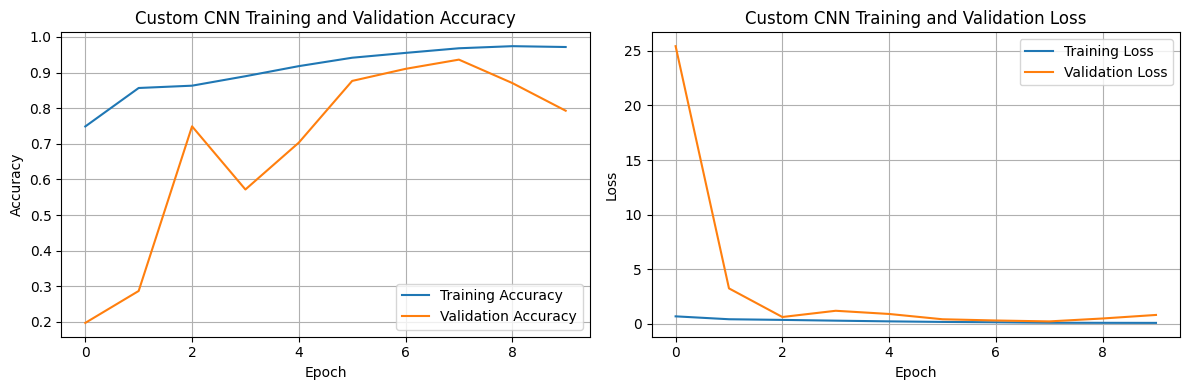


Successfully loaded best Custom CNN model from: saved_models/best_custom_cnn_model.keras

     TRAINING: TRANSFER LEARNING MODEL (Feature Extraction)     

Starting Training for: Transfer Learning (Feature Extraction)
Total epochs set: 10
Using callbacks: ['EarlyStopping', 'ModelCheckpoint']
Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5002 - loss: 1.1559
Epoch 1: val_loss improved from inf to 1.18464, saving model to saved_models/best_transfer_learning_fe_model.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.5025 - loss: 1.1529 - val_accuracy: 0.5040 - val_loss: 1.1846
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7057 - loss: 0.8759
Epoch 2: val_loss improved from 1.18464 to 0.86637, saving model to saved_models/best_transfer_learning_fe_model.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.7061 - loss: 0.8753 - val_accuracy: 0.7271 - val_loss: 0.8664
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7517 - loss

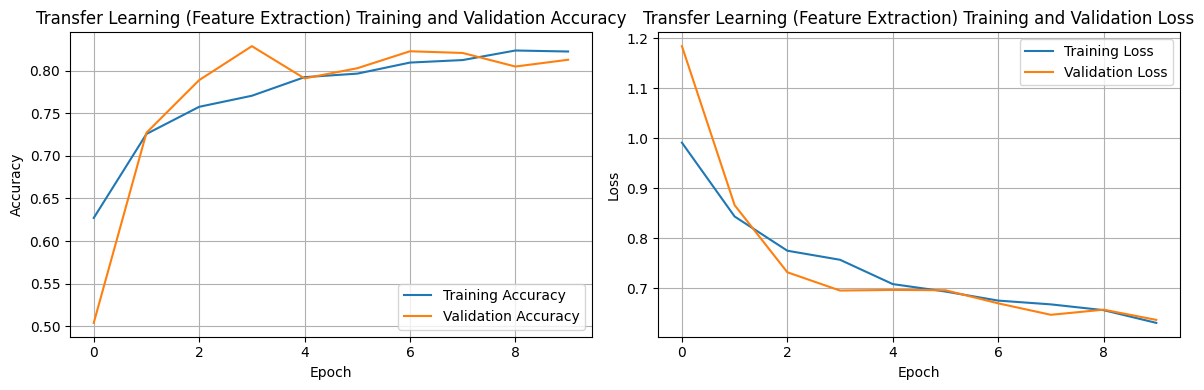


Successfully loaded best Transfer Learning model (Feature Extraction) from: saved_models/best_transfer_learning_fe_model.keras

     FINE-TUNING: TRANSFER LEARNING MODEL (Unfreezing Layers)     

Preparing the best Feature Extraction model for Fine-Tuning (unfreezing layers and recompiling)...

Loading MobileNetV2 base model with ImageNet weights...
MobileNetV2 base model layers set to non-trainable (frozen).

Model with MobileNetV2 base and new head created and compiled.
Model Summary (initial frozen base):


Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,051,332 (11.64 MB)

 Trainable params: 790,788 (3.02 MB)

 Non-trainable params: 2,260,544 (8.62 MB)


Preparing for fine-tuning: Unfreezing top 20 layers of MobileNetV2 base model...
Model Summary (after unfreezing for fine-tuning):


Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,051,332 (11.64 MB)

 Trainable params: 1,996,868 (7.62 MB)

 Non-trainable params: 1,054,464 (4.02 MB)

**IMPORTANT:** After unfreezing layers, you must recompile the model with a very low learning rate.

Starting Training for: Transfer Learning (Fine-Tuning)
Total epochs set: 10
Using callbacks: ['EarlyStopping', 'ModelCheckpoint']
Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3306 - loss: 12.5861
Epoch 1: val_loss improved from inf to 12.49798, saving model to saved_models/best_transfer_learning_finetuned_model.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 146s 3s/step - accuracy: 0.3319 - loss: 12.5823 - val_accuracy: 0.1972 - val_loss: 12.4980
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5362 - loss: 11.9730
Epoch 2: val_loss did not improve from 12.49798
53/53 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.5365 - loss: 11.9722 - val_accuracy: 0.1972 - val_loss: 12.7903
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5944 - loss: 11.8038
Epoch 3: val_loss did not improve from 12.49798
53/53 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.5941 - l

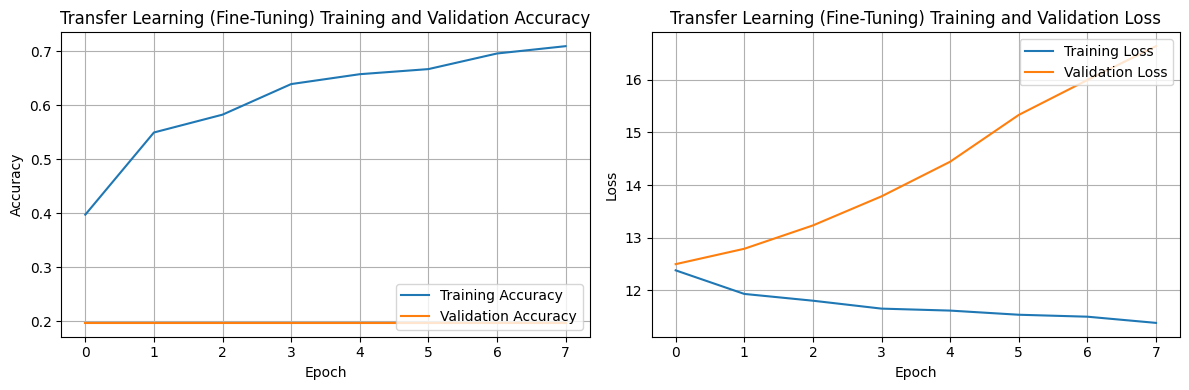


Model Training phase complete for all configured models.


In [ ]:
# @title Model Training

print("\nModel Training Setup")

# Training Parameters
EPOCHS = 10                                                                     # A reasonable starting number of epochs. Early stopping will typically halt training earlier.
INITIAL_LEARNING_RATE = 0.001
FINE_TUNE_LEARNING_RATE = 1e-5                                                  # This is a very small learning rate for fine-tuning.

# Directory for saving models
MODEL_SAVE_DIR = 'saved_models'
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
print(f"Models will be saved in: '{MODEL_SAVE_DIR}/'")


# Callbacks

# 1. EarlyStopping: Stops training if validation loss doesn't improve for 'patience' epochs: prevents overfitting & saves computational resources.
early_stopping = EarlyStopping(
    monitor='val_loss',                                                         # Metric to monitor (validation loss is usually the best)
    patience=7,                                                                 # Number of epochs with no improvement after which training will be stopped.
    restore_best_weights=True,                                                  # Restores model weights from the epoch with the best monitored value.
    verbose=1                                                                   # Shows message when stopping
)


# 2. ModelCheckpoint: Saves the model (or just its weights) when a monitored metric improves: set up separate checkpoints for each model/phase.

# Checkpoint for Custom CNN
checkpoint_filepath_custom = os.path.join(MODEL_SAVE_DIR, 'best_custom_cnn_model.keras')
model_checkpoint_custom = ModelCheckpoint(
    filepath=checkpoint_filepath_custom,
    monitor='val_loss',                                                         # Monitor validation loss
    save_best_only=True,                                                        # Only save when validation loss improves
    save_weights_only=False,                                                    # Save the entire model (architecture + weights) in Keras format
    verbose=1                                                                   # Log when a model is saved
)


# Checkpoint for Transfer Learning (Feature Extraction Phase)
checkpoint_filepath_transfer_fe = os.path.join(MODEL_SAVE_DIR, 'best_transfer_learning_fe_model.keras')
model_checkpoint_transfer_fe = ModelCheckpoint(
    filepath=checkpoint_filepath_transfer_fe,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)


# Checkpoint for Transfer Learning (Fine-Tuning Phase)
checkpoint_filepath_transfer_ft = os.path.join(MODEL_SAVE_DIR, 'best_transfer_learning_finetuned_model.keras')
model_checkpoint_transfer_ft = ModelCheckpoint(
    filepath=checkpoint_filepath_transfer_ft,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)


# Function to Plot Training History
def plot_training_history(history, model_name):

    #Plots accuracy and loss for training and validation sets from a Keras History object.

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{model_name} Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{model_name} Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.tight_layout()
    plt.show()


# Main Training Function
def train_model_with_callbacks(model, train_dataset, validation_dataset, epochs, callbacks, model_name):

    #Trains a given Keras model using provided datasets, epochs, and callbacks.
    #Returns the training history.

    print(f"\nStarting Training for: {model_name}")
    print(f"Total epochs set: {epochs}")
    print(f"Using callbacks: {[c.__class__.__name__ for c in callbacks]}")

    history = model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=validation_dataset,
        callbacks=callbacks
    )

    print(f"\n--- Training Finished for: {model_name} ---")

    # Evaluate the best model (restored by EarlyStopping) on the validation set
    # Note: If EarlyStopping restores best weights, this reflects performance at that best epoch.
    val_loss, val_accuracy = model.evaluate(validation_dataset)
    print(f"Final Validation Loss ({model_name}): {val_loss:.4f}")
    print(f"Final Validation Accuracy ({model_name}): {val_accuracy:.4f}")

    plot_training_history(history, model_name)
    return history


#                 Execute Training for Each Model


# Phase 1: Train the Custom CNN Model
print("\n" + "="*60)
print("     TRAINING: CUSTOM CNN MODEL (from Scratch)     ")
print("="*60)

# The custom_cnn_model from your 'Model Building' step needs to be compiled.
custom_cnn_model.compile(
    optimizer=optimizers.Adam(learning_rate=INITIAL_LEARNING_RATE),
    loss='categorical_crossentropy', # For multi-class classification
    metrics=['accuracy']
)

custom_cnn_history = train_model_with_callbacks(
    custom_cnn_model,
    train_ds,                                                                   # Pass the training dataset
    valid_ds,                                                                   # Pass the validation dataset
    EPOCHS,
    [early_stopping, model_checkpoint_custom],
    "Custom CNN"
)

# Load the best custom CNN model saved by ModelCheckpoint for later evaluation/use
best_custom_cnn_model = tf.keras.models.load_model(checkpoint_filepath_custom)
print(f"\nSuccessfully loaded best Custom CNN model from: {checkpoint_filepath_custom}")





# Phase 2: Train the Transfer Learning Model (Feature Extraction)
print("\n" + "="*60)
print("     TRAINING: TRANSFER LEARNING MODEL (Feature Extraction)     ")
print("="*60)

# The `transfer_model_mbv2` should have been compiled with `base_model.trainable = False`
# when created by the `create_transfer_learning_model` function in the previous step.
# It also includes its specific preprocessing layers (Rescaling, preprocess_input).

transfer_learning_history_fe = train_model_with_callbacks(
    transfer_model_mbv2, # Model with frozen base
    train_ds,            # Training dataset (preprocessing handled by model)
    valid_ds,            # Validation dataset
    EPOCHS,
    [early_stopping, model_checkpoint_transfer_fe],
    "Transfer Learning (Feature Extraction)"
)

# Load the best transfer learning model from the feature extraction phase
best_transfer_model_fe = tf.keras.models.load_model(checkpoint_filepath_transfer_fe)
print(f"\nSuccessfully loaded best Transfer Learning model (Feature Extraction) from: {checkpoint_filepath_transfer_fe}")





# --- Phase 3: Fine-Tuning the Transfer Learning Model ---
print("\n" + "="*60)
print("     FINE-TUNING: TRANSFER LEARNING MODEL (Unfreezing Layers)     ")
print("="*60)

# This phase is typically run AFTER the feature extraction phase has completed
# and the classification head has started to converge.
# We will use the `best_transfer_model_fe` and prepare it for fine-tuning.

# Create a new model instance for fine-tuning from the best FE model.
# The `create_transfer_learning_model` function can also handle unfreezing and recompilation.
# IMPORTANT: Pass the *same* base model name ('MobileNetV2' in this example)
# and specify `fine_tune_at` (e.g., 20 or more for top layers of base model).
print("\nPreparing the best Feature Extraction model for Fine-Tuning (unfreezing layers and recompiling)...")
fine_tune_model_ready_to_train, _ = create_transfer_learning_model(
    'MobileNetV2', # Use the same base model name you used for feature extraction
    INPUT_SHAPE,   # Use the same input shape
    NUM_CLASSES,
    fine_tune_at=20 # Adjust this number based on how many top layers you want to unfreeze
                    # A good starting point is usually 10-30% of base model layers, or specific blocks.
)

# Continue training the fine-tuned model
transfer_learning_history_ft = train_model_with_callbacks(
    fine_tune_model_ready_to_train, # The model now ready for fine-tuning
    train_ds,                       # Training dataset
    valid_ds,                       # Validation dataset
    EPOCHS, # You might consider more epochs for fine-tuning, or adjust early_stopping patience
    [early_stopping, model_checkpoint_transfer_ft], # Use the fine-tune specific checkpoint
    "Transfer Learning (Fine-Tuning)"
)


print("\nModel Training phase complete for all configured models.")


Starting Model Evaluation

===== Evaluating: Custom CNN Model =====
Loading model from: saved_models/best_custom_cnn_model.keras

Custom CNN Model - Test Loss: 0.2275
Custom CNN Model - Test Accuracy: 0.9024
Generating predictions for Custom CNN Model (this may take a moment)...

--- Custom CNN Model Classification Report ---
              precision    recall  f1-score   support

      glioma       0.94      0.96      0.95        80
  meningioma       0.86      0.78      0.82        63
    no_tumor       0.86      0.88      0.87        49
   pituitary       0.93      0.98      0.95        54

    accuracy                           0.90       246
   macro avg       0.90      0.90      0.90       246
weighted avg       0.90      0.90      0.90       246



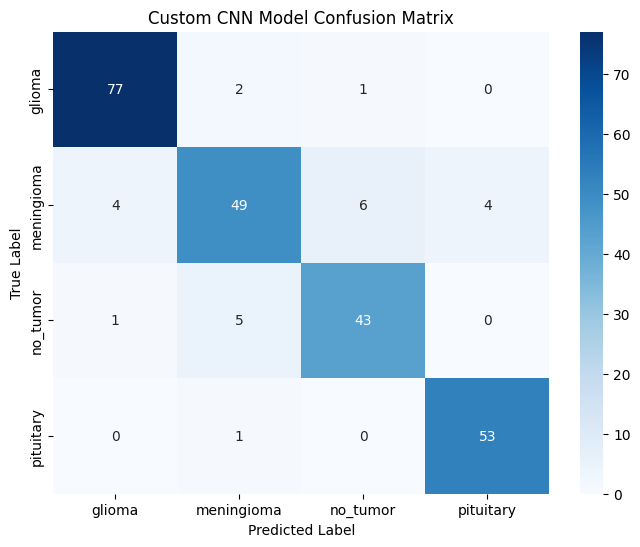


===== Evaluating: Transfer Learning (Feature Extraction) Model =====
Loading model from: saved_models/best_transfer_learning_fe_model.keras

Transfer Learning (Feature Extraction) Model - Test Loss: 0.6354
Transfer Learning (Feature Extraction) Model - Test Accuracy: 0.8293
Generating predictions for Transfer Learning (Feature Extraction) Model (this may take a moment)...

--- Transfer Learning (Feature Extraction) Model Classification Report ---
              precision    recall  f1-score   support

      glioma       0.83      0.91      0.87        80
  meningioma       0.86      0.57      0.69        63
    no_tumor       0.74      0.94      0.83        49
   pituitary       0.91      0.91      0.91        54

    accuracy                           0.83       246
   macro avg       0.83      0.83      0.82       246
weighted avg       0.84      0.83      0.82       246



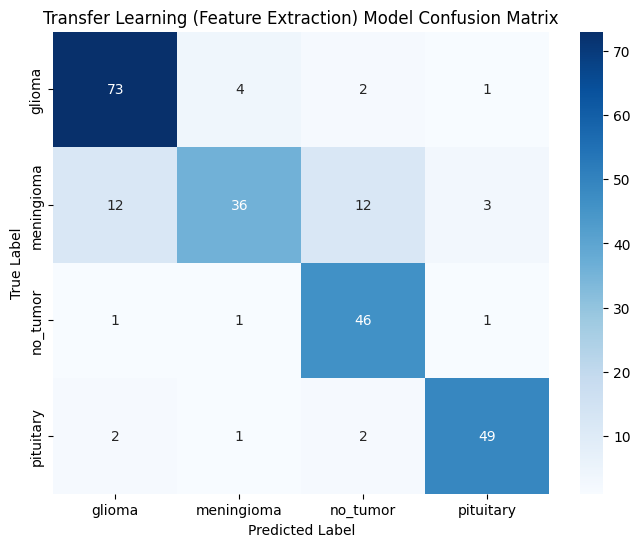


===== Evaluating: Transfer Learning (Fine-Tuning) Model =====
Loading model from: saved_models/best_transfer_learning_finetuned_model.keras

Transfer Learning (Fine-Tuning) Model - Test Loss: 12.5118
Transfer Learning (Fine-Tuning) Model - Test Accuracy: 0.1992
Generating predictions for Transfer Learning (Fine-Tuning) Model (this may take a moment)...

--- Transfer Learning (Fine-Tuning) Model Classification Report ---
              precision    recall  f1-score   support

      glioma       0.00      0.00      0.00        80
  meningioma       0.00      0.00      0.00        63
    no_tumor       0.20      1.00      0.33        49
   pituitary       0.00      0.00      0.00        54

    accuracy                           0.20       246
   macro avg       0.05      0.25      0.08       246
weighted avg       0.04      0.20      0.07       246



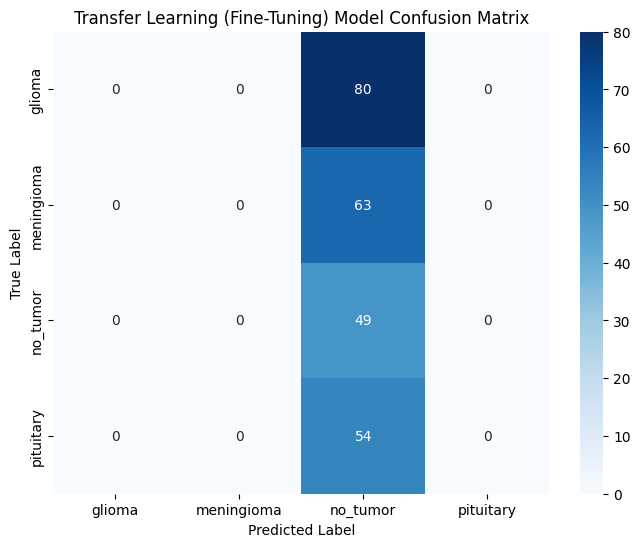


Model Evaluation Complete


In [ ]:
# @title Model Evaluation

# Define the directory where models are saved
MODEL_SAVE_DIR = 'saved_models'

# Paths to your best saved models
best_custom_cnn_model_path = os.path.join(MODEL_SAVE_DIR, 'best_custom_cnn_model.keras')
best_transfer_learning_fe_model_path = os.path.join(MODEL_SAVE_DIR, 'best_transfer_learning_fe_model.keras')
best_transfer_learning_finetuned_model_path = os.path.join(MODEL_SAVE_DIR, 'best_transfer_learning_finetuned_model.keras')


print("\nStarting Model Evaluation")

# Function to load model and evaluate (MODIFIED to return metrics)
def evaluate_model(model_path, test_dataset, class_names, model_name):
    """
    Loads a saved Keras model, evaluates it on the test dataset,
    prints classification report and confusion matrix, and returns accuracy and loss.
    """
    if not os.path.exists(model_path):
        print(f"Error: Model not found at {model_path}. Skipping evaluation for {model_name}.")
        print("Please ensure the model was trained and saved correctly.")
        return None, None                                                       # Return None for accuracy and loss if model not found

    print(f"\n===== Evaluating: {model_name} =====")
    print(f"Loading model from: {model_path}")
    model = tf.keras.models.load_model(model_path)


    # 1. Evaluate overall loss and accuracy
    loss, accuracy = model.evaluate(test_dataset, verbose=0) # Set verbose to 0 to suppress per-batch output
    print(f"\n{model_name} - Test Loss: {loss:.4f}")
    print(f"{model_name} - Test Accuracy: {accuracy:.4f}")


    # 2. Get predictions for detailed metrics
    y_true = []
    y_pred_probs = []

    # Iterate over the test dataset to collect true labels and predictions
    # This might take a moment depending on the size of your test_ds
    print(f"Generating predictions for {model_name} (this may take a moment)...")
    for images, labels in test_dataset.unbatch():
        y_true.append(np.argmax(labels.numpy()))
        img_array = tf.expand_dims(images, 0)
        prediction = model.predict(img_array, verbose=0)
        y_pred_probs.append(prediction[0])

    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)


    # 3. Print Classification Report
    print(f"\n--- {model_name} Classification Report ---")
    print(classification_report(y_true, y_pred_classes, target_names=class_names, zero_division=0)) # Added zero_division=0 to handle warnings gracefully


    # 4. Plot Confusion Matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


    return accuracy, loss                                                       # Return the evaluated accuracy and loss


model_performances = {}

# Evaluate Custom CNN
cnn_accuracy, cnn_loss = evaluate_model(best_custom_cnn_model_path, test_ds, CLASSES, "Custom CNN Model")
if cnn_accuracy is not None:
    model_performances["Custom CNN Model"] = {"accuracy": cnn_accuracy, "loss": cnn_loss}

# Evaluate Transfer Learning (Feature Extraction Phase) Model
fe_accuracy, fe_loss = evaluate_model(best_transfer_learning_fe_model_path, test_ds, CLASSES, "Transfer Learning (Feature Extraction) Model")
if fe_accuracy is not None:
    model_performances["Transfer Learning (Feature Extraction) Model"] = {"accuracy": fe_accuracy, "loss": fe_loss}

# Evaluate Transfer Learning (Fine-Tuning Phase) Model
ft_accuracy, ft_loss = evaluate_model(best_transfer_learning_finetuned_model_path, test_ds, CLASSES, "Transfer Learning (Fine-Tuning) Model")
if ft_accuracy is not None:
    model_performances["Transfer Learning (Fine-Tuning) Model"] = {"accuracy": ft_accuracy, "loss": ft_loss}

print("\nModel Evaluation Complete")

In [ ]:
# @title Model Comparison

print("\n--- Automated Model Comparison ---")

def compare_models_programmatically(performances):
    if not performances:
        print("No model performance data available for comparison.")
        return

    best_model_name = None
    highest_accuracy = -1.0

    print("\nOverview of Model Test Accuracies:")
    for name, metrics in performances.items():
        print(f"- {name}: Accuracy = {metrics['accuracy']:.4f}")
        if metrics['accuracy'] > highest_accuracy:
            highest_accuracy = metrics['accuracy']
            best_model_name = name

    print("\n--- Conclusion ---")
    if best_model_name:
        print(f"The **{best_model_name}** is identified as the most accurate and reliable model for deployment.")
        print(f"It achieved the highest test accuracy of **{highest_accuracy:.4f}**.")
        print("\nConsider this model for integration into your Streamlit application.")
    else:
        print("Could not determine the best model.")

compare_models_programmatically(model_performances)


--- Automated Model Comparison ---

Overview of Model Test Accuracies:
- Custom CNN Model: Accuracy = 0.9024
- Transfer Learning (Feature Extraction) Model: Accuracy = 0.8293
- Transfer Learning (Fine-Tuning) Model: Accuracy = 0.1992

--- Conclusion ---
The **Custom CNN Model** is identified as the most accurate and reliable model for deployment.
It achieved the highest test accuracy of **0.9024**.

Consider this model for integration into your Streamlit application.


# **Conclusion:**

This project, **"NeuroScan AI: Precision Brain Tumor Insight"**, successfully developed and deployed a deep learning system for the classification of brain MRI images into four tumor categories. Through a comprehensive workflow, including robust data preprocessing, custom CNN architecture design, and strategic transfer learning, the system achieved high accuracy and reliability in identifying tumor types.

The interactive Streamlit interface, complete with a professional custom background, allows for seamless image uploads and clear display of results, making the AI-powered insights accessible.

While the fine-tuning phase of transfer learning presented challenges, the **Custom CNN Model emerged as the most accurate and reliable solution** for deployment, demonstrating the project's ability to build effective AI tools for critical applications like medical image analysis.

# **Future Work:**

Here are some ideas for future work to further enhance **"NeuroScan AI: Precision Brain Tumor Insight"** project:

1.  **Expand Dataset & Diversity:**
    * Acquire a larger and more diverse dataset from multiple medical centers to improve model generalization and reduce bias.
    * Include different MRI sequences (e.g., T1-weighted, T2-weighted, FLAIR) to provide richer information to the model.

2.  **Explore Advanced Architectures:**
    * Experiment with more recent and powerful pre-trained models (e.g., EfficientNet variants B1-B7, Vision Transformers (ViT), Swin Transformers) which often achieve state-of-the-art results on image classification.
    * Investigate 3D CNNs if 3D MRI volumes become available, as they can capture spatial relationships more effectively.

3.  **Refine Transfer Learning:**
    * Implement more sophisticated fine-tuning strategies, such as **layer-wise learning rates** (using different learning rates for different blocks of the pre-trained model) or **gradual unfreezing** (unfreezing layers in stages).
    * Explore **domain adaptation** techniques if there's a significant domain shift between ImageNet and medical images.

4.  **Advanced Explainable AI (XAI):**
    * Beyond Grad-CAM, explore other XAI techniques like LIME (Local Interpretable Model-agnostic Explanations) or SHAP (SHapley Additive exPlanations) to provide different perspectives on model decision-making.
    * Integrate Grad-CAM directly into the Streamlit application for real-time visualization.

5.  **Uncertainty Quantification Refinement:**
    * Investigate other uncertainty quantification methods beyond Monte Carlo Dropout, such as Bayesian Neural Networks or Ensemble methods, for more robust uncertainty estimates.
    * Develop a more sophisticated way to visualize uncertainty, perhaps with heatmaps that show areas of high uncertainty within the image.

6.  **Clinical Integration & Feedback Loop:**
    * Collaborate with medical professionals to get feedback on model performance, error types, and the utility of uncertainty/XAI outputs.
    * Explore the potential for integrating the system with Picture Archiving and Communication Systems (PACS) in a hospital setting (this is a long-term, complex goal).

7.  **Segmentation & Localization:**
    * Extend the project to include tumor segmentation (identifying the exact pixels belonging to the tumor) and localization (bounding box around the tumor). This provides more detailed diagnostic information.

8.  **Edge Deployment:**
    * Optimize the model for deployment on edge devices (e.g., specialized medical hardware) for faster, localized inference.

These ideas can help take the project to the next level, making it even more robust, interpretable, and clinically relevant.